# Parameter Estimation - SIR model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-rate parameters: 
    b_samples = np.random.normal(-1.0, 0.3, size=(batch_size, 1))
    c_samples = np.random.normal(-1.5, 0.3, size=(batch_size, 1))
    p_samples = np.c_[b_samples, c_samples]
    return p_samples.astype(np.float32)


# ODE model for SIR dynamics
def sir_dynamics(t, x, theta):
    theta = 10**theta
    return np.array([
            -theta[0]*x[0]*x[1]/N, 
            theta[0]*x[0]*x[1]/N - theta[1]*x[1],
            theta[1]*x[1]
            ])

N = 1000   # population size
x0 = np.array([999, 1, 0])   # initial state       
sigma = 0.015   # noise standard deviation
t_end = 180
n_obs = 31
time_points = np.linspace(0, t_end, n_obs)
missing_max = 15


def batch_simulator(prior_samples, n_obs):  
    """
    Simulate multiple SIR model datasets with missing values and augmentation by zeros/ones
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.ones((n_sim, n_obs, 4), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.random.randint(0, missing_max+1, size=n_sim) 
    
    for m in range(n_sim):
        rhs = lambda t,x: sir_dynamics(t, x, prior_samples[m])
        sol = solve_ivp(rhs, t_span=(0, t_end), y0=x0, t_eval=time_points, atol=1e-9, rtol=1e-6)
        sim_data[m, :, 0:3] = sol.y.T/N + np.random.normal(0, sigma, size=(n_obs, 3))     # observable: y = x + N(0,sigma²)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, -1.0, -1.0, 0.0])
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [128, 128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [5]:
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

We connect the prior and simulator through a *GenerativeModel* class which will take care of forward inference.

In [6]:
generative_model = GenerativeModel(prior, batch_simulator)

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True,
)

In [8]:
trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=generative_model,
    learning_rate = lr_schedule,
    checkpoint_path = './SIR_augment01_5ACB_[128,128,128]_LSTM(128)_ckpts',
    max_to_keep=300,
    skip_checks=True
)

Networks loaded from ./SIR_augment01_5ACB_[128,128,128]_LSTM(128)_ckpts\ckpt-300


### Online training

In [9]:
%%time
losses = trainer.train_online(epochs=300, iterations_per_epoch=1000, batch_size=64, n_obs=n_obs)

Training epoch 1:   0%|          | 0/50 [00:00<?, ?it/s]

Wall time: 13.6 s


epoch: 200, 250, 300

loss: -8.76, -8.80, -8.77

## Computational faithfulness

In [9]:
def batch_simulator_analysis(prior_samples, n_obs):  
    sim_data = np.ones((1, n_obs, 4), dtype=np.float32) 
    n_missing = 15 #np.random.randint(0, missing_max+1)
    
    rhs = lambda t,x: sir_dynamics(t, x, prior_samples[0])
    sol = solve_ivp(rhs, t_span=(0, t_end), y0=x0, t_eval=time_points, atol=1e-9, rtol=1e-6)
    data_original = sol.y.T/N + np.random.normal(0, sigma, size=(n_obs, 3))    
    sim_data[0, :, 0:3] = data_original  
        
    # artificially induce missing data
    missing_indices = random.sample(range(n_obs), n_missing)
    present_indices = np.setdiff1d(range(n_obs), missing_indices)
    sim_data[0][missing_indices] = np.array([-1.0, -1.0, -1.0, 0.0])
    
    # returns original data, present indices, present timepoints, augmented data
    return [data_original, present_indices, time_points[present_indices], sim_data] 

In [10]:
param_prior = np.array([[-1.2, -1.1]]).astype(np.float32) #prior(1)   
result = batch_simulator_analysis(param_prior, n_obs)
x_data = result[3]
n_post_samples = 7500 
param_samples = amortizer.sample(x_data, n_post_samples)   # BayesFlow samples from the learned posterior
param_prior[0]

array([-1.2, -1.1], dtype=float32)

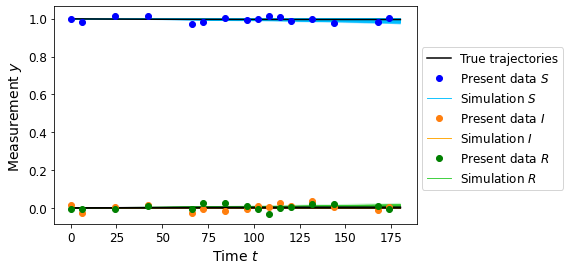

In [11]:
# Posterior predictive check
fig = plt.figure(figsize=(6.5, 4))
plt.rcParams['font.size'] = 12

for k in range(501):
    rhs = lambda t,x: sir_dynamics(t, x, param_samples[k])
    sol = solve_ivp(rhs, t_span = (0,t_end), y0 = x0, atol = 1e-9, rtol = 1e-6)
    if k == 0:
        plt.plot(sol.t[0], sol.y[0,0]/N, color='deepskyblue', label='Simulation $S$', linewidth=0.9)
        plt.plot(sol.t[0], sol.y[1,0]/N, color='orange', label='Simulation $I$', linewidth=0.9)
        plt.plot(sol.t[0], sol.y[2,0]/N, color='limegreen', label='Simulation $R$', linewidth=0.9)
    else: 
        plt.plot(sol.t, sol.y[0]/N, color='deepskyblue', linewidth=0.5, alpha=0.3)
        plt.plot(sol.t, sol.y[1]/N, color='orange', linewidth=0.5, alpha=0.3)
        plt.plot(sol.t, sol.y[2]/N, color='limegreen', linewidth=0.5, alpha=0.3)

rhs = lambda t,x: sir_dynamics(t, x, param_prior[0])
sol = solve_ivp(rhs, t_span = (0,t_end), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[0]/N, color='black', label='True trajectories') 
plt.plot(sol.t, sol.y[1]/N, color='black')   
plt.plot(sol.t, sol.y[2]/N, color='black') 
plt.plot(time_points[result[1]], x_data[0,result[1],0], 'o', color='blue', label='Present data $S$')
plt.plot(time_points[result[1]], x_data[0,result[1],1], 'o', color='tab:orange', label='Present data $I$')
plt.plot(time_points[result[1]], x_data[0,result[1],2], 'o', color='green', label='Present data $R$')

plt.xlabel('Time $t$', fontsize=14)
plt.ylabel('Measurement $y$', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,4,0,5,1,6,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12, bbox_to_anchor=(1.42,0.84))
plt.show()
fig.savefig("figures/{}_Re-simulation.png".format('SIR_4(500)'), dpi=600, bbox_inches='tight')

In [12]:
result

[array([[ 1.00057094e+00,  1.61041716e-02, -4.21639406e-03],
        [ 9.80104975e-01, -2.68505259e-02, -6.72866846e-03],
        [ 9.98861118e-01,  2.04340537e-02, -4.53298909e-03],
        [ 9.77094734e-01, -1.68939183e-02,  6.40067119e-03],
        [ 1.01144943e+00,  7.10039635e-03, -5.29880209e-03],
        [ 1.00083159e+00,  5.71093067e-03,  9.35926685e-03],
        [ 9.94347493e-01,  5.21919784e-03,  6.57762209e-03],
        [ 1.01274857e+00,  1.39114664e-02,  1.19341422e-02],
        [ 1.00723400e+00, -1.14062140e-02,  3.08068060e-04],
        [ 1.01719789e+00,  5.90274177e-03,  1.62683888e-02],
        [ 1.00115115e+00, -1.51618489e-02, -1.08304938e-02],
        [ 9.70706225e-01, -2.64629468e-02, -4.67735444e-03],
        [ 9.81964633e-01, -5.04203093e-03,  2.65455652e-02],
        [ 9.93796102e-01, -8.46611019e-03,  1.52761974e-02],
        [ 1.00423490e+00, -1.51453925e-02,  2.82261670e-02],
        [ 1.01476287e+00, -4.90652275e-03,  2.59496380e-02],
        [ 9.94100860e-01

In [13]:
def prior_eval(b,c):   
    # Evaluates prior probability p(theta) according to b ~ N(-1.0, 0.3²) and c ~ N(-1.5, 0.3²) 
    return norm.pdf(b,-1.0, 0.3) * norm.pdf(c,-1.5, 0.3)

def likelihood(b,c):   
    # Calculates likelihood p(x_{1:N} | theta) of the available data
    rhs = lambda t,x: sir_dynamics(t, x, np.array([b,c]))
    sol = solve_ivp(rhs, t_span = (0,t_end), t_eval = result[2], y0 = x0, atol = 1e-9, rtol = 1e-6)
    residual = (result[0][result[1]] - sol.y.T/N)/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior(b,c):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return likelihood(b,c) * prior_eval(b,c)

In [14]:
# scaling factor
mean_sample = np.mean(param_samples, axis=0)
cov_sample = np.cov(param_samples.transpose())
mean_x = mean_sample[0]
mean_y = mean_sample[1]
std_x = np.sqrt(cov_sample[0, 0])
std_y = np.sqrt(cov_sample[1, 1])

scaling_factor = dblquad(unnormalized_posterior, mean_y-6*std_y, mean_y+6*std_y, lambda y: mean_x-6*std_x, lambda y: mean_x+6*std_x)
print(scaling_factor)

# normalized posterior
posterior_xy = lambda x,y: unnormalized_posterior(x,y)/scaling_factor[0]
posterior_eval = lambda theta: posterior_xy(theta[0], theta[1])
posterior_at_prior = posterior_eval(param_prior[0])
print(posterior_at_prior)

(1.2805443634124532e+57, 2.7141935637028046e+49)
4.329506032609549


In [15]:
# Level sets of analytic posterior distribution
grid = 201
A = np.linspace(mean_x - 3.5 * std_x, mean_x + 3.5 * std_x, grid)
B = np.linspace(mean_y - 3.5 * std_y, mean_y + 3.5 * std_y, grid)
true_posterior = np.zeros((grid, grid))
for iy in range(0, grid):
    for ix in range(0, grid):
        true_posterior[iy][ix] = posterior_xy(A[ix], B[iy])
        
# Marginal densities        
grid = 151
A = np.linspace(mean_x - 5 * std_x, mean_x + 5 * std_x, grid)
B = np.linspace(mean_y - 5 * std_y, mean_y + 5 * std_y, grid)
bounds = np.array([mean_x - 6 * std_x, mean_x + 6 * std_x, mean_y - 6 * std_y, mean_y + 6 * std_y])
marginal_x = np.zeros(grid)
for i in range(grid):
    x = A[i]
    integrand_y = lambda y: posterior_xy(x, y)
    marginal_x[i] = quad(integrand_y, bounds[2], bounds[3])[0]
marginal_y = np.zeros(grid)
for j in range(grid):
    y = B[j]
    integrand_x = lambda x: posterior_xy(x, y)
    marginal_y[j] = quad(integrand_x, bounds[0], bounds[1])[0]

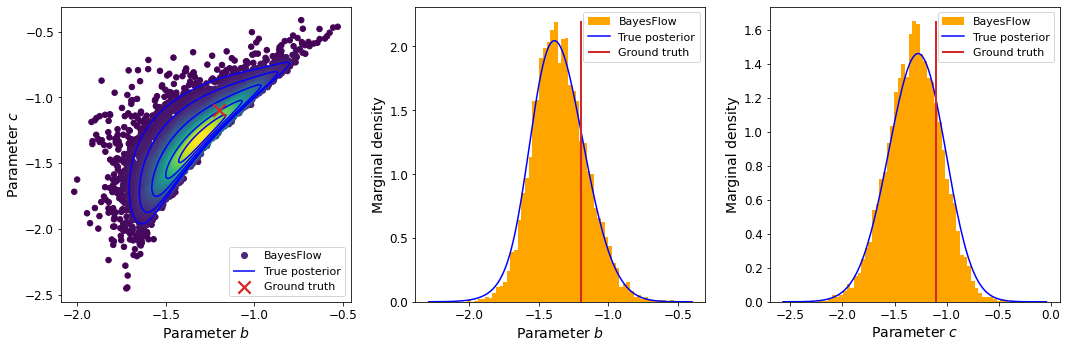

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.rcParams['font.size'] = 12
    
plt.subplot(1, 3, 1)
grid = 201
A = np.linspace(mean_x - 3.5 * std_x, mean_x + 3.5 * std_x, grid)
B = np.linspace(mean_y - 3.5 * std_y, mean_y + 3.5 * std_y, grid)
levels = np.array([0.5, 1, 2.25, 4.5, 6.75])
true_posterior_2D = plt.contour(A, B, true_posterior, levels, colors='blue')
h1, _ = true_posterior_2D.legend_elements()
#plt.clabel(true_posterior_2D, fontsize=9, inline=1)
# Kernel density estimator of BayesFlow samples
a = param_samples[:, 0]
b = param_samples[:, 1]
ab = np.vstack([a, b])
z = stats.gaussian_kde(ab)(ab)
ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
a, b, z = a[ida], b[ida], z[ida]
approximate_posterior = plt.scatter(a, b, c=z, s=30)
h2, _ = approximate_posterior.legend_elements()
true = plt.scatter(param_prior[0, 0], param_prior[0, 1], c="tab:red", marker="x", s=150, linewidths=2.25, zorder=2)
plt.legend([h2[0], h1[0], true], ['BayesFlow', 'True posterior', 'Ground truth'], fontsize=11, loc='lower right')
plt.xticks([-2.0, -1.5, -1.0, -0.5])
plt.yticks([-2.5, -2.0, -1.5, -1.0, -0.5])
plt.xlabel('Parameter $b$', fontsize=14)
plt.ylabel('Parameter $c$', fontsize=14)

grid = 151
A = np.linspace(mean_x - 5 * std_x, mean_x + 5 * std_x, grid)
B = np.linspace(mean_y - 5 * std_y, mean_y + 5 * std_y, grid)
plt.subplot(1, 3, 2)
plt.hist(param_samples[:, 0], bins='auto', density=1, color='orange', label='BayesFlow')
plt.plot(A, marginal_x, color='b', label='True posterior')
plt.vlines(param_prior[0,0], 0, 2.2, colors='tab:red', linestyles='solid', label='Ground truth', linewidths=2.)
plt.ylabel('Marginal density', fontsize=14)
plt.xlabel('Parameter $b$', fontsize=14)
plt.legend(fontsize=11)
plt.subplot(1, 3, 3)
plt.hist(param_samples[:, 1], bins='auto', density=1, color='orange', label='BayesFlow')
plt.plot(B, marginal_y, color='b', label='True posterior')
plt.vlines(param_prior[0,1], 0, 1.65, colors='tab:red', linestyles='solid', label='Ground truth', linewidths=2.)
plt.ylabel('Marginal density', fontsize=14)
plt.xlabel('Parameter $c$', fontsize=14)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()
fig.savefig("figures/{}_posterior.png".format('SIR_4'), dpi=600, bbox_inches='tight')

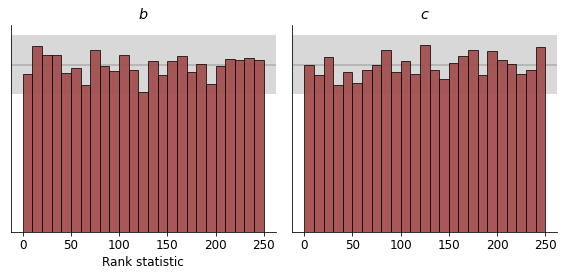

In [30]:
# simulation-based calibration
n_sbc = 5000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_sbc = batch_simulator(params_sbc, n_obs)
param_samples = amortizer.sample(x_sbc, n_post_samples_sbc)
f = plot_sbc(param_samples, params_sbc, param_names=['$b$', '$c$'], filename='SIR')

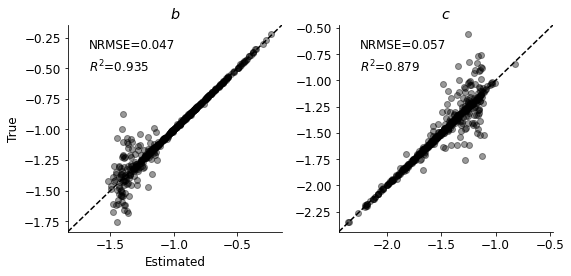

In [33]:
# Validation metrics
true_params = prior(500) 
x = batch_simulator(true_params, n_obs).astype(np.float32)
param_samples = amortizer.sample(x, n_samples=1000) 
param_means = param_samples.mean(axis=1)
f = true_vs_estimated(true_params, param_means, ['$b$', '$c$'], filename='SIR')